# RippleNet_training_bidirectional
Simple bidirectional recurrent neural network (RNN) implementation in Keras using LSTM (long short-term memory) units to identify time of occurence of sharp wave ripple (SPW-R) events in temporal data.

In [24]:
# allow running on Google Colab for training. 
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    %cd gdrive/My\ Drive/Colab\ Notebooks/NN_Ripple_Detection/neural_networks
    %tensorflow_version 2.x
except:
    pass

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/My Drive/Colab Notebooks/NN_Ripple_Detection/neural_networks'
/content/gdrive/My Drive/Colab Notebooks/NN_Ripple_Detection/neural_networks


In [0]:
%matplotlib inline

In [0]:
import os
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
import ripplenet.models
import h5py
import pickle
import random

In [27]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15976026264238533929
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5179751351510951331
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6988826640331788324
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11150726272
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8275895718017437449
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [28]:
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.2.0-rc3
/device:GPU:0
Num GPUs Available:  1


In [0]:
# set random seeds with some additional environment variables to ensure deterministic output
random_seed = 789
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED']=str(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [0]:
# select dataset (may have generated different sets.)
dataset_index = 0 

# Load training/validation data

In [0]:
# select species for training/validation data (mouse, rat or both)
mouse = True
rat = True

In [0]:
# output destination
output_folder = 'trained_networks'
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

# prefix for trained network files (training loss/MSE, weights, `best' weights)
rnn_prefix = 'ripplenet_bidirectional'

In [0]:
if mouse:
    # training and validation files
    f_name_train = 'train_{:02}.h5'
    f_name_val = 'validation_{:02}.h5'

    # training data
    f = h5py.File(os.path.join('..', 'data', 'processed', 
                               f_name_train.format(dataset_index)), 
                  'r')
    X_train = np.expand_dims(f['X0'][:], -1)
    Y_train = f['Y'][:]
    f.close()

    # validation data
    f = h5py.File(os.path.join('..', 'data', 'processed', 
                               f_name_val.format(dataset_index)), 
                  'r')
    X_val = np.expand_dims(f['X0'][:], -1)
    Y_val = f['Y'][:]
    f.close()

    # load some data for plotting
    f = h5py.File(os.path.join('..', 'data', 'processed', 
                               f_name_val.format(dataset_index)), 'r')
    X0 = f['X0'][:]
    X1 = f['X1'][:]
    S = f['S'][:]
    Y = f['Y'][:]
    S_freqs = f['S_freqs'][:]
    f.close()

In [0]:
# Add rat training/validation data to sets
if rat and mouse:
    # rat 
    f_name_train = 'train_buzsaki_{:02}.h5'
    f_name_val = 'validation_buzsaki_{:02}.h5'

    # training data
    f = h5py.File(os.path.join('..', 'data', 'processed', 
                            f_name_train.format(dataset_index)), 
                'r')
    X_train = np.concatenate((X_train, np.expand_dims(f['X0'][:], -1)))
    Y_train = np.concatenate((Y_train, f['Y'][:]))
    f.close()

    # validation data
    f = h5py.File(os.path.join('..', 'data', 'processed', 
                            f_name_val.format(dataset_index)), 
                'r')
    X_val = np.concatenate((X_val, np.expand_dims(f['X0'][:], -1)))
    Y_val = np.concatenate((Y_val, f['Y'][:]))
    f.close()

    # load some data for plotting
    f = h5py.File(os.path.join('..', 'data', 'processed', 
                            f_name_val.format(dataset_index)), 'r')
    X0 = np.concatenate((X0, f['X0'][:]))
    X1 = np.concatenate((X1, f['X1'][:]))
    S = np.concatenate((S, f['S'][:]))
    Y = np.concatenate((Y, f['Y'][:]))
    f.close()

In [0]:
if rat and not mouse:
    # rat 
    f_name_train = 'train_buzsaki_{:02}.h5'
    f_name_val = 'validation_buzsaki_{:02}.h5'

    # training data
    f = h5py.File(os.path.join('..', 'data', 'processed', 
                               f_name_train.format(dataset_index)), 
                  'r')
    X_train = np.expand_dims(f['X0'][:], -1)
    Y_train = f['Y'][:]
    f.close()

    # validation data
    f = h5py.File(os.path.join('..', 'data', 'processed', 
                               f_name_val.format(dataset_index)), 
                  'r')
    X_val = np.expand_dims(f['X0'][:], -1)
    Y_val = f['Y'][:]
    f.close()

    # load some data for plotting
    f = h5py.File(os.path.join('..', 'data', 'processed', 
                               f_name_val.format(dataset_index)), 'r')
    X0 = f['X0'][:]
    X1 = f['X1'][:]
    S = f['S'][:]
    Y = f['Y'][:]
    S_freqs = f['S_freqs'][:]
    f.close()

In [0]:
# needed parameters
Fs = 1250 # Hz, sampling freq
time = np.arange(X0.shape[1]) / Fs

# center raw data
X0 = (X0.T - X0.mean(axis=-1)).T

# total number of samples
n_samples = X0.shape[0]

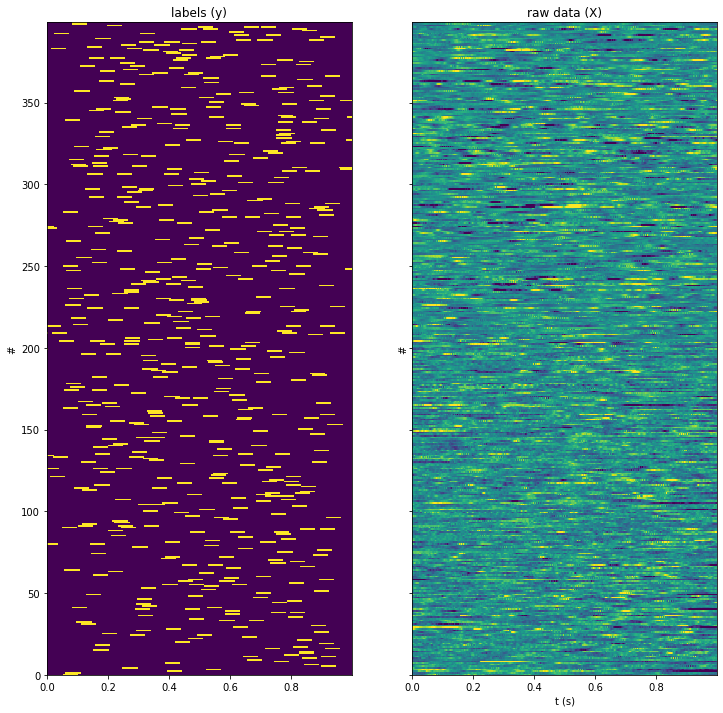

In [37]:
# plot all labels and raw data matrices
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 12))
axes[0].pcolormesh(time, np.arange(n_samples), Y[:, :, 0])
axes[0].set_ylabel('#')
axes[0].set_title('labels (y)')
axes[1].pcolormesh(time, np.arange(n_samples), X0, vmin=-X0.std()*3, vmax=X0.std()*3)
axes[1].set_ylabel('#')
axes[1].set_xlabel('t (s)')
axes[1].set_title('raw data (X)')
for ax in axes:
    ax.axis(ax.axis('tight'))

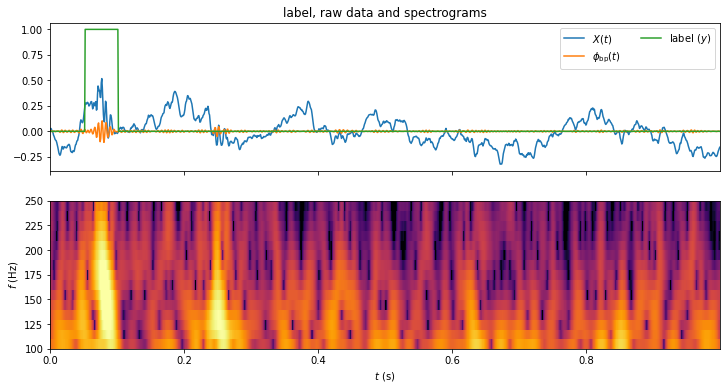

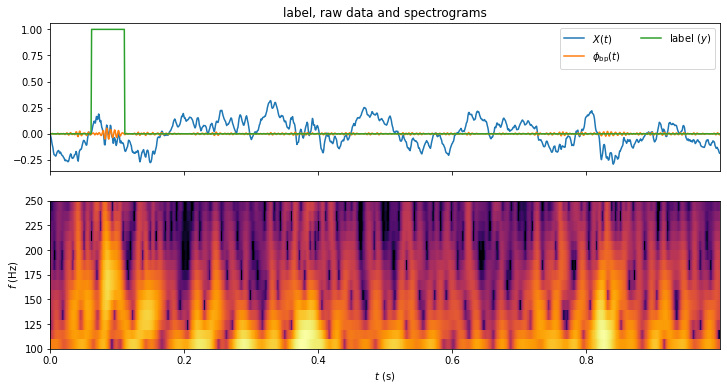

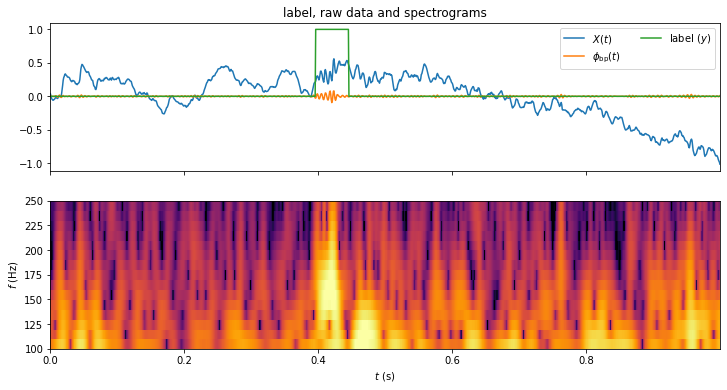

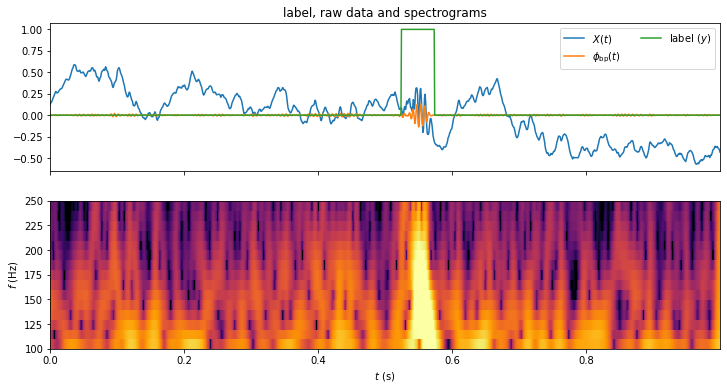

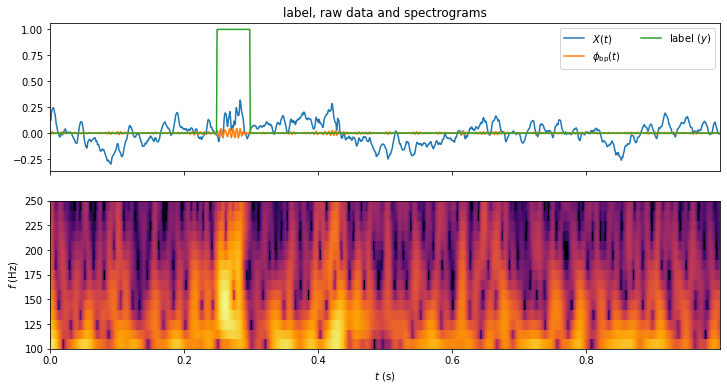

In [38]:
# plot wavelet spectrograms vs. labels and raw data for some samples
for i in range(5):
    gs = GridSpec(2, 1)
    fig = plt.figure(figsize=(12, 6))
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.plot(time, X0[i, ], label='$X(t)$')
    ax0.plot(time, X1[i, ], label=r'$\phi_\mathrm{bp}(t)$')
    ax0.plot(time, Y[i, :, 0], label='label ($y$)' )
    ax0.legend(ncol=2)
    ax0.axis(ax0.axis('tight'))
    ax0.set_title('label, raw data and spectrograms')
    plt.setp(ax0.get_xticklabels(), visible=False)
    
    ax1 = fig.add_subplot(gs[1:, 0], sharex=ax0)
    vmin, vmax = np.exp(np.percentile(np.log(S), [1, 99]))
    im = ax1.pcolormesh(time, S_freqs, S[i, ].T, norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                        cmap='inferno')
    ax1.axis(ax1.axis('tight'))
    ax1.set_ylabel('$f$ (Hz)')
    ax1.set_xlabel('$t$ (s)')

# Set up recurrent neural network

In [0]:
model = ripplenet.models.get_bidirectional_LSTM_model(input_shape=(None, X_train.shape[2]), 
                                                      layer_sizes=[20, 10, 6, 6],
                                                      seed=random_seed+1)

In [40]:
model.summary()

Model: "RippleNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, None, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 20)          220       
_________________________________________________________________
batch_normalization (BatchNo (None, None, 20)          80        
_________________________________________________________________
dropout (Dropout)            (None, None, 20)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 10)          2210      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 10)          40

In [0]:
# plot_model(model, show_shapes=True, expand_nested=True)

In [0]:
# model checkpoints when validation mse improves
filepath = os.path.join(output_folder, '{}_best_random_seed{}.h5'.format(rnn_prefix, random_seed))
checkpoint_best = keras.callbacks.ModelCheckpoint(filepath, monitor='val_mse', 
                                             verbose=1, save_best_only=True, 
                                             mode='min')
callback_hist = keras.callbacks.CSVLogger(os.path.join(output_folder, '{}_history_random_seed{}.csv'.format(rnn_prefix, random_seed)))
callbacks_list = [checkpoint_best, callback_hist]

In [43]:
# train model
history = model.fit(X_train, Y_train, 
                    batch_size=20, 
                    epochs=50, 
                    callbacks=callbacks_list,
                    validation_data=(X_val, Y_val))

Epoch 1/50
409/409 [==============================] - ETA: 0s - loss: 0.1483 - mse: 0.0435
Epoch 00001: val_mse improved from inf to 0.05205, saving model to trained_networks/ripplenet_bidirectional_best_random_seed789.h5
409/409 [==============================] - 241s 589ms/step - loss: 0.1483 - mse: 0.0435 - val_loss: 0.2010 - val_mse: 0.0520
Epoch 2/50
409/409 [==============================] - ETA: 0s - loss: 0.0906 - mse: 0.0262
Epoch 00002: val_mse improved from 0.05205 to 0.02526, saving model to trained_networks/ripplenet_bidirectional_best_random_seed789.h5
409/409 [==============================] - 236s 577ms/step - loss: 0.0906 - mse: 0.0262 - val_loss: 0.0892 - val_mse: 0.0253
Epoch 3/50
409/409 [==============================] - ETA: 0s - loss: 0.0804 - mse: 0.0235
Epoch 00003: val_mse improved from 0.02526 to 0.01924, saving model to trained_networks/ripplenet_bidirectional_best_random_seed789.h5
409/409 [==============================] - 238s 582ms/step - loss: 0.0804 - 

In [0]:
# save history to a pickle so we can load it later
with open(os.path.join(output_folder, '{}_history_random_seed{}.pkl'.format(rnn_prefix, random_seed)), 'wb') as f:
    pickle.dump(history.history, f)

Text(0.5, 1.0, 'training/validation MSE')

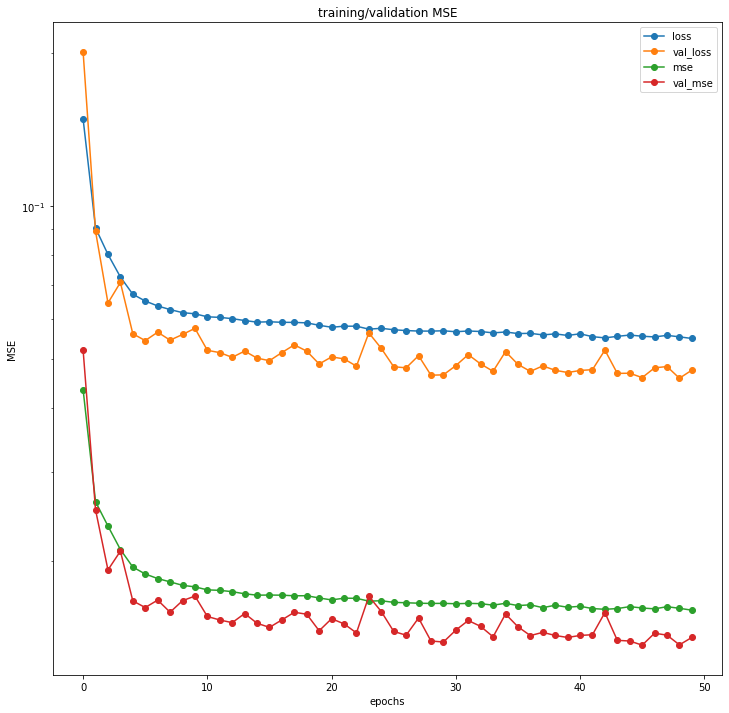

In [45]:
plt.figure(figsize=(12, 12))
plt.semilogy(history.history['loss'], '-o', label='loss')
plt.semilogy(history.history['val_loss'], '-o', label='val_loss')
plt.semilogy(history.history['mse'], '-o', label='mse')
plt.semilogy(history.history['val_mse'], '-o', label='val_mse')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.title('training/validation MSE')

In [0]:
# Save the trained model
model.save(os.path.join(output_folder, '{}_random_seed{}.h5'.format(rnn_prefix, random_seed)))